<a href="https://colab.research.google.com/github/rnayebi21/PolygenceMLResearch-scRNAseq/blob/main/Gene_Expression_Brain_cells_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First get the imports ready

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import seaborn as sns
from collections import Counter

from sklearn import metrics
from sklearn import model_selection, linear_model
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

sns.set()

Next we must log into google drive to access the files

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Gathering the metadata from google drive via the IDs of each google file

In [ ]:
Pilocytic_Astrocytoma_Metadata_ID = "1Q2-7lvQVWQH6K7T23vCfHN6KKpdjyyuJ"
Brain_file = drive.CreateFile({'id':Pilocytic_Astrocytoma_Metadata_ID})
Brain_file.GetContentFile('metadata3_20181216.txt')
Brain_metadata = pd.read_csv("metadata3_20181216.txt", sep = "\t")


Brain_gene_expression_ID = "10KBUSNHD_0NmcX8KkLhiVgTyf5RXseY7"
Brain_GE_file = drive.CreateFile({'id':Brain_gene_expression_ID})
Brain_GE_file.GetContentFile('Pilocytic_astro.txt')
Brain_GE = pd.read_csv("Pilocytic_astro.txt", sep = "\t")

In [ ]:
print("meta dims: " + str(np.shape(Brain_metadata)) + "\ngene expression dims: " + str(np.shape(Brain_GE)))

meta dims: (932, 6)
gene expression dims: (18265, 943)


In [ ]:
Brain_GE

,GENE,BT618_1,BT618_2,BT618_3,BT618_4,BT618_5,BT618_6,BT618_7,BT618_8,BT618_11,BT618_12,BT618_13,BT618_14,BT618_18,BT618_19,BT618_20,BT618_21,BT618_22,BT618_23,BT618_24,BT618_25,BT618_26,BT618_27,BT618_28,BT618_30,BT618_32,BT618_33,BT618_34,BT618_36,BT618_37,BT618_38,BT618_40,BT618_41,BT618_42,BT618_43,BT618_46,BT618_48,BT618_49,BT618_50,BT618_51,...,BT827_A2B5POSPLT4080417_C5,BT827_A2B5POSPLT4080417_C7,BT827_A2B5POSPLT4080417_D10,BT827_A2B5POSPLT4080417_D11,BT827_A2B5POSPLT4080417_D1,BT827_A2B5POSPLT4080417_D2,BT827_A2B5POSPLT4080417_D3,BT827_A2B5POSPLT4080417_D4,BT827_A2B5POSPLT4080417_D5,BT827_A2B5POSPLT4080417_D7,BT827_A2B5POSPLT4080417_E10,BT827_A2B5POSPLT4080417_E11,BT827_A2B5POSPLT4080417_E1,BT827_A2B5POSPLT4080417_E3,BT827_A2B5POSPLT4080417_E4,BT827_A2B5POSPLT4080417_E5,BT827_A2B5POSPLT4080417_E9,BT827_A2B5POSPLT4080417_F10,BT827_A2B5POSPLT4080417_F11,BT827_A2B5POSPLT4080417_F1,BT827_A2B5POSPLT4080417_F2,BT827_A2B5POSPLT4080417_F3,BT827_A2B5POSPLT4080417_F4,BT827_A2B5POSPLT4080417_F5,BT827_A2B5POSPLT4080417_F7,BT827_A2B5POSPLT4080417_F9,BT827_A2B5POSPLT4080417_G11,BT827_A2B5POSPLT4080417_G2,BT827_A2B5POSPLT4080417_G3,BT827_A2B5POSPLT4080417_G4,BT827_A2B5POSPLT4080417_G5,BT827_A2B5POSPLT4080417_G7,BT827_A2B5POSPLT4080417_G9,BT827_A2B5POSPLT4080417_H10,BT827_A2B5POSPLT4080417_H11,BT827_A2B5POSPLT4080417_H2,BT827_A2B5POSPLT4080417_H3,BT827_A2B5POSPLT4080417_H5,BT827_A2B5POSPLT4080417_H7,BT827_A2B5POSPLT4080417_H9
0,A1BG,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,2.97,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
1,A1BG-AS1,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,10.56,0.00,0.00,128.12,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,174.63,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.89,0.0,0.0,0.00,0.00,64.93,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
2,A1CF,0.00,0.00,11.48,0.00,67.43,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
3,A2M,0.00,0.00,2.75,4717.97,2.07,0.0,3.72,0.0,0.0,272.07,0.00,280.88,47.99,3158.92,4184.42,2619.70,0.00,1586.41,0.0,2234.21,0.0,0.0,0.00,4436.43,0.0,5.58,3.64,49.30,4060.99,7.11,0.00,25.74,770.65,4037.23,0.0,0.0,1411.49,6771.91,3.36,...,7.09,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,3.89,0.00,0.0,1.30,0.00,0.00,0.00,0.00,0.00,0.0,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,1.82,0.0,0.00,0.0,0.00,0.0
4,A2M-AS1,0.00,0.00,0.00,12.26,0.00,0.0,0.00,0.0,0.0,0.00,0.00,1.40,0.00,0.00,6.22,0.00,0.00,2.99,0.0,0.00,0.0,0.0,0.00,9.43,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.60,4.78,0.0,0.0,1.94,54.21,0.00,...,0.00,0.00,0.0,0.00,0.00,113.78,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,67.13,6.51,0.00,0.00,0.00,0.0,0.00,0.00,0.00,47.82,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18260,ZYG11A,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.0

In [ ]:
Brain_GE.index = Brain_GE["GENE"]
Brain_GE = Brain_GE.drop("GENE", axis = 1)
Brain_GE.index.name=""
Brain_GE = Brain_GE.transpose()
Brain_GE["cells"] = Brain_GE.index
future_ind = []
for i in range(0,942):
  future_ind.append(i)
Brain_GE.index = future_ind
Brain_GE = Brain_GE.sort_values(by="cells")
Brain_GE.index = Brain_GE["cells"]
Brain_GE.index.name=""
Brain_GE = Brain_GE.drop("cells", axis=1)
Brain_GE

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,AAAS,AACS,AACSP1,AADAC,AADACP1,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,AARD,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA2,ABCA3,ABCA4,ABCA5,...,ZSCAN1,ZSCAN12,ZSCAN12P1,ZSCAN16,ZSCAN16-AS1,ZSCAN18,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN25,ZSCAN26,ZSCAN29,ZSCAN30,ZSCAN31,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN9,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZSWIM8,ZSWIM8-AS1,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BT618_1,0.00,0.00,0.0,0.00,0.0,3.88,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,76.72,0.00,23.49,52.68,0.0,61.06,0.00,148.55,0.00,132.49,0.00,403.65,17.18,7.20,0.00,34.71,51.31,0.0,11.37,0.00,0.00,0.00,0.00,0.00,0.0,7.85,...,0.0,1.68,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,14.16,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,4.17,0.00,0.0,0.00,119.28,0.0,0.00,0.00,0.00,0.00,0.0,30.66,76.29,0.00,0.00
BT618_11,0.00,0.00,0.0,0.00,0.0,0.00,0.00,1012.33,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,556.32,0.00,0.0,0.00,0.00,177.35,0.00,0.00,0.00,0.00,11.80,0.00,10.94,196.84,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,16.34,...,0.0,0.00,0.00,0.00,0.0,488.01,0.0,0.0,0.00,0.00,0.0,0.00,0.00,4.95,0.00,0.00,0.00,0.0,7.59,0.00,0.00,0.00,0.0,0.0,0.00,0.00,224.16,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
BT618_12,0.00,0.00,0.0,272.07,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,311.41,58.79,0.00,317.39,0.0,0.00,0.00,497.00,0.00,430.56,0.00,0.00,8.15,0.00,0.00,0.00,184.78,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.00,0.00,0.00,0.0,1.29,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,2.84,0.00,259.76,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,97.13,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
BT618_13,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,436.11,0.00,0.00,0.00,0.0,201.37,18.69,122.92,3.25,0.00,0.00,625.33,47.24,122.32,0.00,32.24,119.98,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.00,3.86,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,11.28,38.53,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,25.86,0.0,14.76,0.00,55.6,0.00,0.00,0.00,0.00,0.0,0.00,35.26,0.00,252.53
BT618_14,2.97,10.56,0.0,280.88,1.4,0.00,0.00,88.29,0.00,0.0,0.0,0.0,0.00,7.32,29.83,0.70,49.11,46.67,0.0,8.50,0.00,33.43,0.00,49.80,14.80,45.11,4.54,54.90,0.00,0.00,48.23,0.0,3.29,0.00,0.00,0.00,1.39,0.00,0.0,0.00,...,0.0,4.44,0.00,0.00,0.0,10.55,0.0,0.0,8.82,0.00,0.0,0.00,0.00,0.68,4.26,0.00,2.28,0.0,0.00,0.00,0.36,10.23,0.0,0.0,11.61,12.04,0.80,0.0,210.94,0.34,2.2,0.00,0.00,2.03,0.00,0.0,13.86,17.59,1.88,6.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BT906_plt3_p65,0.00,0.00,0.0,5.31,0.0,0.00,49.54,340.13,0.00,0.0,0.0,0.0,12.62,0.00,24.79,0.00,0.00,289.03,0.0,0.00,0.00,113.47,0.00,0.00,36.20,89.69,37.43,0.00,38.66,138.34,0.00,0.0,0.00,5.96,0.00,0.00,0.00,58.68,0.0,20.63,...,0.0,0.00,0.00,45.93,0.0,181.45,0.0,0.0,0.00,10.65,0.0,0.00,144.89,0.00,0.00,0.00,0.00,0.0,0.00,16.82,0.00,0.00,0.0,0.0,4.45,100.96,20.48,0.0,0.00,78.11,0.0,0.00,0.00,0.00,0.00,0.0,35.53,136.87,0.00,0.00
BT906_plt3_p66,0.00,0.00,0.0,336.55,0.0,0.00,0.00,0.00,22.57,0.0,0.0,0.0,43.75,15.35,0.00,0.05,701.72,317.19,0.0,0.00,28.24,192.46,4.83,609.58,0.00,77.37,10.68,0.00,20.27,280.12,0.09,0.0,6.31,0.00,0.00,0.00,3.99,70.89,0.4,1.17,...,0.0,0.00,0.00,0.00,0.0,68.93,0.0,0.0,0.00,0.00,0.0,2.32,29.22,0.00,0.00,0.41,0.00,0.0,0.00,39.47,0.00,3.69,0.0,0.0,0.36,0.00,0.67,0.0,0.00,0.00,0.0,25.48,6.92,0.00,9.33,0.0,1.57,147.61,0.00,0.00
BT906_plt3_p7,50.01,0.00,0.0,145.75,0.0,0.00,0.00,0.00,114.84,0.0,0.0,0.0,20.38,0.00,76.89,2.39,0.00,0.00,0.0,169.18,0.00,56.99,0.

In [ ]:
Brain_metadata

,NAME,tumor,BRAF_qPCR,A2B5,Cluster,Supercluster
0,TYPE,group,group,group,group,group
1,BT618_4,BT618,KIAA1549:BRAF -,A2B5_negative,2,immune cluster
2,BT618_5,BT618,KIAA1549:BRAF -,A2B5_positive,3,immune cluster
3,BT618_19,BT618,KIAA1549:BRAF -,A2B5_negative,2,immune cluster
4,BT618_20,BT618,KIAA1549:BRAF -,A2B5_negative,2,immune cluster
...,...,...,...,...,...,...
927,BT827_A2B5POSPLT4080417_H2,BT827,ND,A2B5_positive,0,tumor cluster
928,BT827_A2B5POSPLT4080417_H3,BT827,ND,A2B5_positive,0,tumor cluster
929,BT827_A2B5POSPLT4080417_H5,BT827,ND,A2B5_positive,0,tumor cluster
930,BT827_A2B5POSPLT4080417_H7,BT827,ND,A2B5_positive,0,tumor cluster


In [ ]:
Brain_metadata = Brain_metadata.sort_values(by="NAME")
Brain_metadata.index = Brain_metadata.NAME
Brain_metadata = Brain_metadata.drop("NAME", axis = 1)
Brain_metadata.index.name = ""
Brain_metadata.drop("TYPE", axis= 0)
Brain_metadata

,tumor,BRAF_qPCR,A2B5,Cluster,Supercluster
,,,,,
BT618_1,BT618,KIAA1549:BRAF +,A2B5_positive,0,tumor cluster
BT618_11,BT618,KIAA1549:BRAF -,A2B5_positive,0,tumor cluster
BT618_12,BT618,KIAA1549:BRAF -,A2B5_positive,0,tumor cluster
BT618_13,BT618,KIAA1549:BRAF +,A2B5_positive,0,tumor cluster
BT618_18,BT618,KIAA1549:BRAF -,A2B5_positive,1,tumor cluster
...,...,...,...,...,...
BT906_plt3_p66,BT906,KIAA1549:BRAF +,A2B5_positive,0,tumor cluster
BT906_plt3_p7,BT906,KIAA1549:BRAF +,A2B5_positive,0,tumor cluster
BT906_plt3_p8,BT906,KIAA1549:BRAF -,A2B5_positive,1,tumor cluster


In [ ]:
common_cells = []
for i in range(len(Brain_GE.index)):
  if Brain_GE.index[i] in Brain_metadata.index:
    common_cells.append(Brain_GE.index[i])
len(common_cells)

931

In [ ]:
Brain_GE_copy = Brain_GE
for i in range(len(Brain_GE_copy.index)):
  if Brain_GE_copy.index[i] not in common_cells:
    Brain_GE = Brain_GE.drop(Brain_GE_copy.index[i], axis = 0)

In [ ]:
Brain_GE

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,AAAS,AACS,AACSP1,AADAC,AADACP1,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,AARD,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA2,ABCA3,ABCA4,ABCA5,...,ZSCAN1,ZSCAN12,ZSCAN12P1,ZSCAN16,ZSCAN16-AS1,ZSCAN18,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN25,ZSCAN26,ZSCAN29,ZSCAN30,ZSCAN31,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN9,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZSWIM8,ZSWIM8-AS1,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BT618_1,0.00,0.0,0.0,0.00,0.0,3.88,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,76.72,0.00,23.49,52.68,0.0,61.06,0.00,148.55,0.00,132.49,0.00,403.65,17.18,7.20,0.00,34.71,51.31,0.0,11.37,0.00,0.00,0.00,0.00,0.00,0.0,7.85,...,0.0,1.68,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,14.16,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,4.17,0.00,0.0,0.00,119.28,0.0,0.00,0.00,0.0,0.00,0.0,30.66,76.29,0.00,0.00
BT618_11,0.00,0.0,0.0,0.00,0.0,0.00,0.00,1012.33,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,556.32,0.00,0.0,0.00,0.00,177.35,0.00,0.00,0.00,0.00,11.80,0.00,10.94,196.84,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,16.34,...,0.0,0.00,0.00,0.00,0.0,488.01,0.0,0.0,0.0,0.00,0.0,0.00,0.00,4.95,0.00,0.00,0.00,0.0,7.59,0.00,0.0,0.00,0.00,0.0,0.00,0.00,224.16,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00
BT618_12,0.00,0.0,0.0,272.07,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,311.41,58.79,0.00,317.39,0.0,0.00,0.00,497.00,0.00,430.56,0.00,0.00,8.15,0.00,0.00,0.00,184.78,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.00,0.00,0.00,0.0,1.29,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,2.84,0.00,259.76,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,97.13,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00
BT618_13,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,436.11,0.00,0.00,0.00,0.0,201.37,18.69,122.92,3.25,0.00,0.00,625.33,47.24,122.32,0.00,32.24,119.98,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.00,3.86,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,11.28,38.53,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,25.86,0.0,14.76,0.00,55.6,0.00,0.00,0.0,0.00,0.0,0.00,35.26,0.00,252.53
BT618_18,0.00,0.0,0.0,47.99,0.0,0.00,0.00,175.51,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,365.40,0.00,267.77,0.00,171.51,97.50,0.00,0.00,20.76,77.69,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,22.50,0.00,10.90,0.00,0.0,0.00,0.00,0.0,0.00,5.34,0.0,0.00,0.00,0.00,0.0,0.00,10.72,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BT906_plt3_p65,0.00,0.0,0.0,5.31,0.0,0.00,49.54,340.13,0.00,0.0,0.0,0.0,12.62,0.00,24.79,0.00,0.00,289.03,0.0,0.00,0.00,113.47,0.00,0.00,36.20,89.69,37.43,0.00,38.66,138.34,0.00,0.0,0.00,5.96,0.00,0.00,0.00,58.68,0.0,20.63,...,0.0,0.00,0.00,45.93,0.0,181.45,0.0,0.0,0.0,10.65,0.0,0.00,144.89,0.00,0.00,0.00,0.00,0.0,0.00,16.82,0.0,0.00,0.00,0.0,4.45,100.96,20.48,0.0,0.00,78.11,0.0,0.00,0.00,0.0,0.00,0.0,35.53,136.87,0.00,0.00
BT906_plt3_p66,0.00,0.0,0.0,336.55,0.0,0.00,0.00,0.00,22.57,0.0,0.0,0.0,43.75,15.35,0.00,0.05,701.72,317.19,0.0,0.00,28.24,192.46,4.83,609.58,0.00,77.37,10.68,0.00,20.27,280.12,0.09,0.0,6.31,0.00,0.00,0.00,3.99,70.89,0.4,1.17,...,0.0,0.00,0.00,0.00,0.0,68.93,0.0,0.0,0.0,0.00,0.0,2.32,29.22,0.00,0.00,0.41,0.00,0.0,0.00,39.47,0.0,3.69,0.00,0.0,0.36,0.00,0.67,0.0,0.00,0.00,0.0,25.48,6.92,0.0,9.33,0.0,1.57,147.61,0.00,0.00
BT906_plt3_p7,50.01,0.0,0.0,145.75,0.0,0.00,0.00,0.00,114.84,0.0,0.0,0.0,20.38,0.00,76.89,2.39,0.00,0.00,0.0,169.18,0.00,56.99,0.00,0.00,27.16,48.26,89.50,0.

In [ ]:
Brain_metadata = Brain_metadata.drop("TYPE", axis = 0)

In [ ]:
list_of_types = []
Brain_metadata_copy = Brain_metadata
for i in range(len(Brain_metadata_copy["Cluster"])):
  if (Brain_metadata_copy["Cluster"])[i] not in list_of_types:
    list_of_types.append((Brain_metadata_copy["Cluster"])[i])
list_of_types    

['0', '1', '2', '3', '4']

Using 2 principal components we will see what our data looks like 

In [ ]:
Brain_labels = Brain_metadata["Cluster"]
labels_df = pd.DataFrame(Brain_labels)

In [ ]:
pca = PCA(n_components=2)

#reducing the gene expression data
principalComponents_Brain_GE = pca.fit_transform(Brain_GE)
principalDf_Brain_GE = pd.DataFrame(data = principalComponents_Brain_GE, columns = ['principal component 1', 'principal component 2'])

In [ ]:
principalDf_Brain_GE.index = labels_df.index
finalDf = pd.concat([principalDf_Brain_GE, labels_df], axis=1, sort=False)

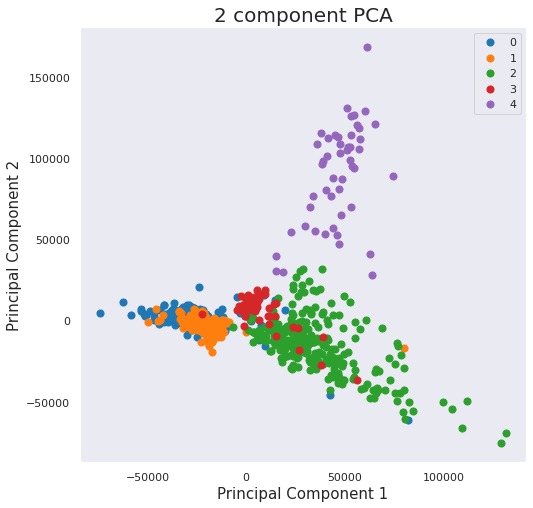

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0', '1', '2', '3', '4']
# colors = ['r', 'g', 'b']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#cbf72d']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf["Cluster"] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


In [ ]:
def confusion_matrix_brain (lbl, pred):
  cm = metrics.confusion_matrix(lbl, pred)
  plt.figure(figsize=(11,11))
  plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
  plt.title('Confusion Matrix', size = 15)
  plt.colorbar()
  tick_marks = np.arange(5)
  plt.xticks(tick_marks, ['0', '1', '2', '3', '4'], rotation = 45, size = 10)
  plt.yticks(tick_marks, ['0', '1', '2', '3', '4'], size = 10)
  plt.tight_layout()
  plt.ylabel('Actual', size = 15)
  plt.xlabel('Predicted', size = 15)
  width, height = cm.shape

  for x in range(width):
    for y in range(height):
      plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

In [ ]:
# scaler = StandardScaler()
# scaler.fit(Brain_GE, Brain_labels)
# Brain_GE_scaled = scaler.transform(Brain_GE)

In [ ]:
# x_train,x_test,train_lbls,test_lbls=train_test_split(Brain_GE_scaled,Brain_labels,test_size=0.3,random_state=0)
x_train,x_test,train_lbls,test_lbls=train_test_split(Brain_GE,Brain_labels,test_size=0.3,random_state=0)

In [ ]:
num_components = np.array([])
for i in range(1, 11):
  delta = (i/2)/10
  pca = PCA(1 - delta)
  pca.fit(x_train)
  num_components = np.append(pca.n_components_, num_components)
  print(*[i, ":", pca.n_components_])

1 : 145
2 : 66
3 : 34
4 : 20
5 : 14
6 : 10
7 : 7
8 : 6
9 : 5
10 : 4


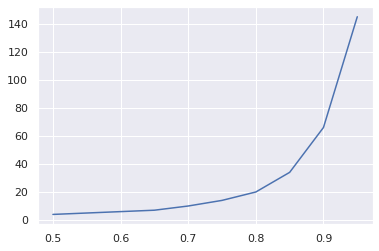

In [ ]:
index_of_PCA =  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
plt.plot(index_of_PCA, num_components)

elbow seems to be at about 0.85


In [ ]:
pca = PCA(0.85)
pca.fit(Brain_GE)
Brain_GE_PCA = pca.transform(Brain_GE)

In [ ]:
pd.DataFrame(Brain_GE_PCA).to_csv("Brain_GE_PCA.csv")
pd.DataFrame(Brain_labels).to_csv("Brain_labels.csv")

#Downloading Pre-processed Files we Created


In [5]:
Brain_labels_df_ID = "1-7Tt4ILGWE8TAksx-fXLqrFxahgqL5hO"
Brain_labels_df_file = drive.CreateFile({'id':Brain_labels_df_ID})
Brain_labels_df_file.GetContentFile('Brain_labels.csv')
Brain_labels_df = pd.read_csv('Brain_labels.csv')


Brain_GE_PCA_ID = "1fkdtANkVEsbgjK56KcMWk7qQQOBSluW0"
Brain_GE_PCA_file = drive.CreateFile({'id':Brain_GE_PCA_ID})
Brain_GE_PCA_file.GetContentFile('Brain_GE_PCA.csv')
Brain_GE_PCA = pd.read_csv('Brain_GE_PCA.csv')

In [6]:
Brain_labels_df.index = Brain_labels_df["Unnamed: 0"]
Brain_labels_df = Brain_labels_df.drop("Unnamed: 0", axis = 1)
Brain_labels_df.index.name = ""

In [7]:
Brain_GE_PCA = Brain_GE_PCA.drop("Unnamed: 0", axis = 1)

In [8]:
train_PCA, test_PCA, train_lbl_PCA, test_lbl_PCA = train_test_split(Brain_GE_PCA, Brain_labels_df, test_size = 0.3, random_state = 1)

Now we want to find the best model that would work for our dataset. We could do the following pipeline code. Except we would miss out on a lot of key details:



```
pipe = Pipeline([("model", KNeighborsClassifier())])
params = [{"model": [linear_model.LogisticRegression()],
           "model__penalty": ["l1", "l2"],
           "model__C": np.logspace(0, 4, num=5)},
          {"model": [linear_model.LogisticRegression()],
            "model__penalty": ['l2'],
            "model__C": np.logspace(0, 4,  num=5),
            "model__solver":['newton-cg','saga','sag','liblinear']},
          {"model": [KNeighborsClassifier()],
           "model__n_neighbors": np.sort(np.append(np.logspace(1.5, 3.1, num=8), 650))},
          {"model": [GaussianNB()]},
          {"model": [svm.SVC()],
           "model__C": np.logspace(-5, 5, num=10),
           "model__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
           "model__degree": np.linspace(1,20, num=10, dtype=int),
           "model__gamma": ['auto', 'scale']},
          {"model": [RandomForestClassifier(oob_score=True)],
           "model__n_estimators": np.logspace(1, 2.4, num=5),
           "model__min_samples_leaf": np.logspace(0,1.7, num=5)}]

           gsearch = GridSearchCV(pipe, params, cv=5,n_jobs=-1, verbose=1)
           best_model = gsearch.fit(train_PCA, train_lbl_PCA)
           print(gsearch.best_params_)
```

Now let's try individual models

#Logistic Regression

In [ ]:
pipe = Pipeline([("model", linear_model.LogisticRegression())])
params = [{"model": [linear_model.LogisticRegression()],
           "model__penalty": ["l1", "l2"],
           "model__C": np.logspace(0, 4, num=5)},
          {"model": [linear_model.LogisticRegression()],
            "model__penalty": ['l2'],
            "model__C": np.logspace(0, 4,  num=5),
            "model__solver":['newton-cg','saga','sag','liblinear']}]

lgr_grid_search = GridSearchCV(pipe, params, cv=5,n_jobs=-1, verbose=1)
lgr = lgr_grid_search.fit(train_PCA, train_lbl_PCA)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
lgr_best_model = lgr.best_estimator_
lgr_best_model

Pipeline(memory=None,
         steps=[('model',
                 LogisticRegression(C=10000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
lgr_best_model_pred = lgr_best_model.predict(test_PCA)
lgr_best_model.score(test_PCA, test_lbl_PCA)

0.8321428571428572

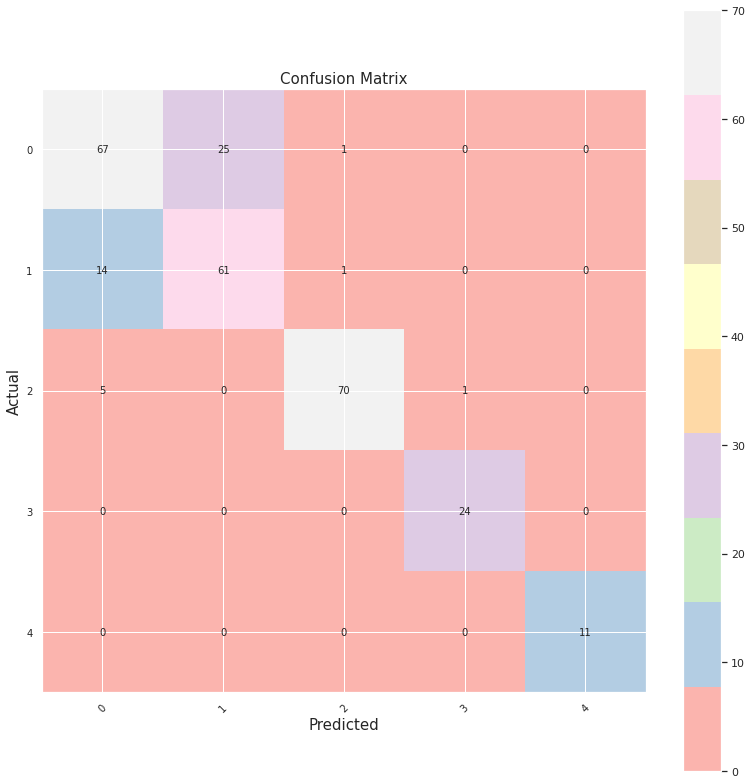

In [ ]:
confusion_matrix_brain(test_lbl_PCA, lgr_best_model_pred)

#KNN

In [ ]:
len(train_PCA)

651

In [ ]:
hypr_params = {'n_neighbors': np.logspace(1.8, 2.6, num=5, dtype = int)}
KNN = KNeighborsClassifier()
GridSearch_KNN = GridSearchCV(KNN, hypr_params, cv=5)

pca_n_components = [2, 3, 4]
for i in range(len(pca_n_components)):
  pca = PCA(n_components=pca_n_components[i])
  pca.fit(Brain_GE)
  pca.transform(Brain_GE)
  train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(Brain_GE, labels_df, test_size = 0.3, random_state = 1)
  GridSearch_KNN.fit(train_x_PCA, train_y_PCA)
  best_model = GridSearch_KNN.best_estimator_
  print("i: " + str(i) + "\nbest model: " + str(best_model) + "\n score of best model: " + str(best_model.score(test_x_PCA, test_y_PCA)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

i: 0
best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=63, p=2,
                     weights='uniform')
 score of best model: 0.7964285714285714


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

i: 1
best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=63, p=2,
                     weights='uniform')
 score of best model: 0.7964285714285714


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

i: 2
best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=63, p=2,
                     weights='uniform')
 score of best model: 0.7964285714285714


Since essentially everything stayed the same, lets drastically increase PCA components and see how it affects the score

In [ ]:
pca = PCA(n_components=100)
pca.fit(Brain_GE)
pca.transform(Brain_GE)
train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(Brain_GE, labels_df, test_size = 0.3, random_state = 1)
GridSearch_KNN.fit(train_x_PCA, train_y_PCA)
best_model = GridSearch_KNN.best_estimator_
print("\nbest model: " + str(best_model) + "\n score of best model: " + str(best_model.score(test_x_PCA, test_y_PCA)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when


best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=63, p=2,
                     weights='uniform')
 score of best model: 0.7964285714285714


still very little difference, for the sake of time we will use the 100 PCs model for the CM, as we have it stored in a currently accessible variable

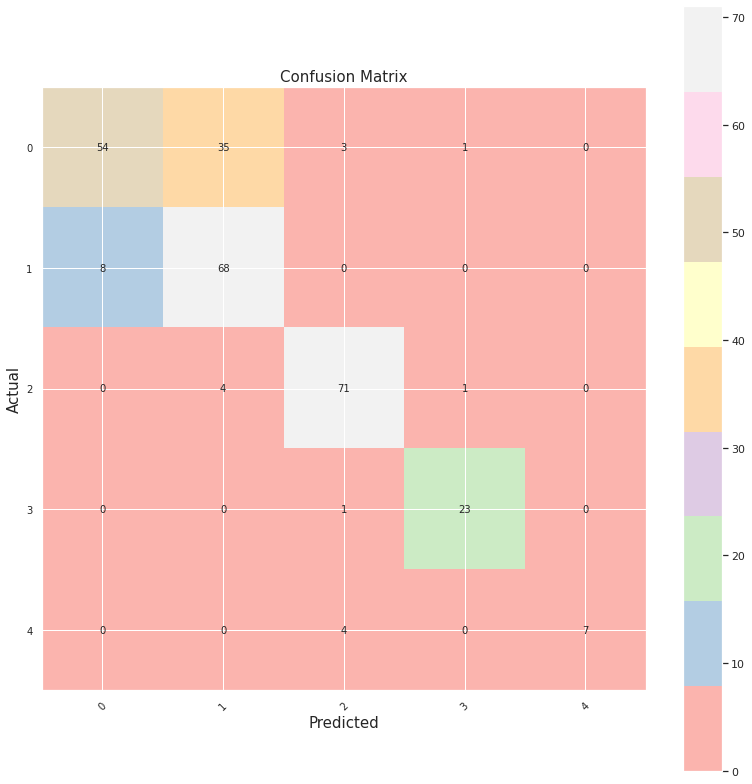

In [ ]:
KNN_best_pred = best_model.predict(test_x_PCA)
confusion_matrix_brain(test_y_PCA, KNN_best_pred)

#Gausain Naive Bayes

In [ ]:
GNB_params_v_smoothing = {"var_smoothing": np.logspace(-64, -25, num=40)}
GNB = GaussianNB()
GNB_grid_search = GridSearchCV(GNB, GNB_params_v_smoothing, cv = 5)

In [ ]:
GNB_grid_search.fit(train_PCA, train_lbl_PCA)
GNB_grid_search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

{'var_smoothing': 1e-64}

In [ ]:
best_GNB_model = GNB_grid_search.best_estimator_
best_GNB_model_pred = best_GNB_model.predict(test_PCA)
best_GNB_model.score(test_PCA, test_lbl_PCA)

0.7892857142857143

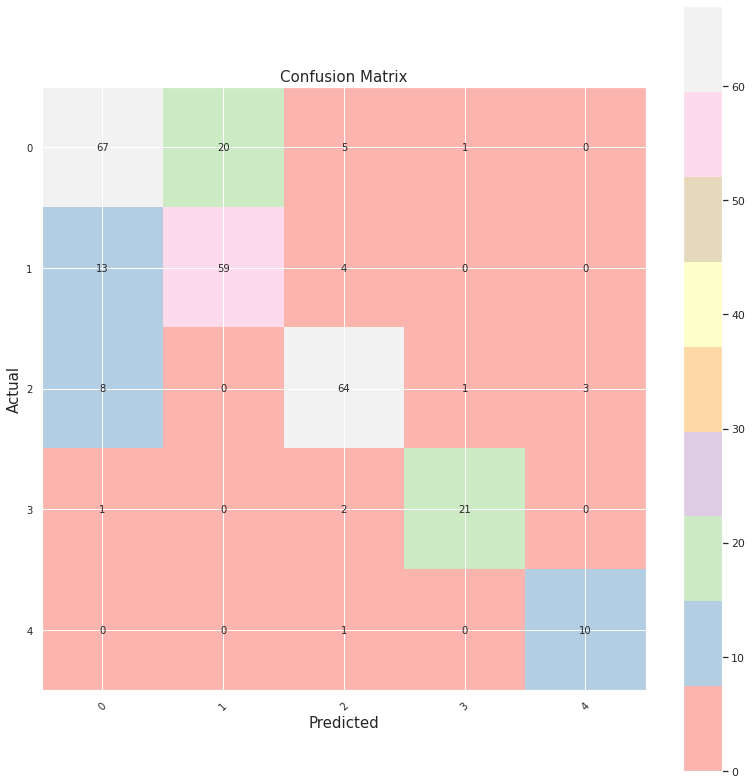

In [ ]:
confusion_matrix_brain(test_lbl_PCA, best_GNB_model_pred)

in the other datasets after using standard scaling on the data, the model performed better so we did this in the notebook titled [Brain Cell GNB PCA + Standard Scaler.ipynb](https://github.com/rnayebi21/PolygenceMLResearch-scRNAseq/blob/main/Brain_Cell_GNB_PCA_%2B_Standard_Scaler.ipynb)

however unlike the other two datasets, scaling the data caused a worse performance. it performed at 45%

#Random Forest!

In [ ]:
RFC_params = {"n_estimators": np.logspace(2.3, 4, num=6, dtype=int),
                "max_features": ['sqrt', 'log2', None]}
RFC = RandomForestClassifier(n_jobs=-1, oob_score=True)
RFC_grid_search = GridSearchCV(RFC, RFC_params, cv = 5)
RFC_grid_search.fit(train_PCA, train_lbl_PCA)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=None,
                                   

In [ ]:
RFC_grid_search.best_params_

{'max_features': 'sqrt', 'n_estimators': 954}

In [ ]:
best_RFC_model = RFC_grid_search.best_estimator_
best_RFC_model_pred = best_RFC_model.predict(test_PCA)
best_RFC_model.score(test_PCA, test_lbl_PCA)

0.8642857142857143

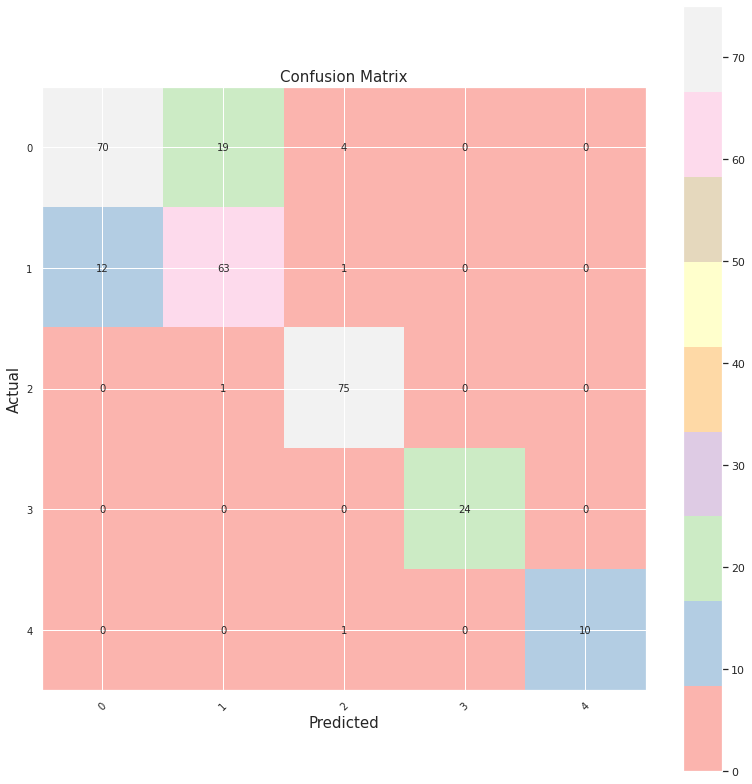

In [ ]:
confusion_matrix_brain(test_lbl_PCA, best_RFC_model_pred)

#Support Vector Machines!

In [ ]:
SVM_pipe = Pipeline([("model", svm.SVC())])
SVM_params = [{"model": [svm.SVC()],
           "model__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
           "model__C": np.logspace(-5, 5, num=5), 
           "model__gamma": ['auto', 'scale']},
          {"model": [svm.SVC()],
            "model__kernel": ['poly'],
            "model__degree": [1,3,5],
            "model__C": np.logspace(-5, 5, num=5),
            "model__gamma": ['auto', 'scale']}]

SVM_grid_search = GridSearchCV(SVM_pipe, SVM_params, cv=5,n_jobs=-1, verbose=1)
SVM = SVM_grid_search.fit(train_PCA, train_lbl_PCA)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 24.3min


In [1]:
SVM_best_model = SVM.best_estimator_
SVM_best_model

In [ ]:
SVM_best_model_pred = SVM_best_model.predict(test_PCA)
SVM_best_model.score(test_PCA, test_lbl_PCA)

In [ ]:
confusion_matrix_brain(test_lbl_PCA, SVM_best_model_pred)